In [1]:
import pandas as pd
import pickle as pkl
import numpy as np

In [2]:
allResults = pkl.load(open("/n/scratch2/ms994/allZeData.pkl", "rb"))

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
labels =  pd.read_csv("/home/ms994/beat_pd/data/cis-pd/data_labels/CIS-PD_Training_Data_IDs_Labels.csv")

In [4]:
train_mid, test_mid = train_test_split(labels.measurement_id.unique(), random_state=1)

In [5]:
train_mid, valid_mid = train_test_split(train_mid, random_state=1)

In [6]:
all_mid = sorted(labels.measurement_id)

In [7]:
train_indices  = [all_mid.index(train_m) for train_m in train_mid]
valid_indices  = [all_mid.index(train_m) for train_m in valid_mid]
test_indices  = [all_mid.index(train_m) for train_m in test_mid]

In [8]:
x = np.array([res[0] for res in allResults])

In [9]:
y = [res[1] for res in allResults]

In [10]:
y = pd.concat(y)

In [11]:
x_std = x.std(axis=1)

In [12]:
x_std = np.nan_to_num(x_std)

In [13]:
mask = ~(pd.isnull(y["tremor"]) | pd.isnull(y["dyskinesia"]) | pd.isnull(y["on_off"]) | (x_std < 0.05).all(1))

In [14]:
x.shape

(204098, 1501, 3)

In [15]:
x[mask].shape

(65545, 1501, 3)

In [16]:
x = x[mask]

In [17]:
y = y[mask]

In [18]:
x = x[:,:1500]

In [19]:
all_m_id = sorted(y.measurement_id.unique())

In [20]:
train_mask = y.measurement_id.isin(train_mid) 

In [21]:
y_train = y[train_mask]

In [22]:
x_train = x[train_mask]

In [23]:
x_train.shape

(36987, 1500, 3)

In [24]:
valid_mask = y.measurement_id.isin(valid_mid)

In [25]:
y_valid = y[valid_mask]
x_valid = x[valid_mask]

# all 3 outputs

In [26]:
import keras
num_cnn_layers = 5
num_lstm_layers = 1
num_lin_layers = 2
inputLayer = keras.layers.Input((1500, 3))
x = inputLayer


for i in range(num_cnn_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv1D(16, (3,), padding="same")(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.MaxPool1D((2,))(x)
for j in range(num_lstm_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.CuDNNLSTM(256, return_sequences=True)(x)
    x = keras.layers.LeakyReLU()(x)


x = keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x = keras.layers.Dense(200)(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dropout(0.5)(x)

x_shared_flattened = x

#one_off
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(256)(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1)(x)
x_on_off = keras.layers.ReLU(name="on_off", max_value=4)(x)

#tremor
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(100)(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1)(x)
x_dyskinesia = keras.layers.ReLU(name="dyskinesia", max_value=4)(x)

#montage classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(100)(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1)(x)
x_tremor = keras.layers.ReLU(name="tremor", max_value=4)(x)



model = keras.Model(inputs=inputLayer, outputs=[x_on_off, x_dyskinesia, x_tremor])

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [27]:
model.compile("adam", loss=["mean_squared_error", "mean_squared_error","mean_squared_error", ])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1500, 3)      0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 1500, 3)      12          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1500, 16)     160         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 1500, 16)     0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [28]:
def train_gen():
    i = 0
    total_num_instances = x_train.shape[0]
    while True:
        yield x_train[i], y_train.on_off.values[i]

In [29]:
modelCheckpoint = keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/cnnlstm3.h5", save_best_only=True, verbose=True)
reduceLR = keras.callbacks.ReduceLROnPlateau(patience=5, verbose=True)
earlyStopping = keras.callbacks.EarlyStopping(patience=20, min_delta=0.01)
lr_schedule = keras.callbacks.LearningRateScheduler(lambda i, lr: lr*0.8)
history = model.fit(x=x_train, y=[y_train.on_off.values, y_train.dyskinesia.values, y_train.tremor.values], validation_data=(x_valid, [y_valid.on_off.values, y_valid.dyskinesia.values,y_valid.tremor.values]), callbacks=[earlyStopping, lr_schedule, modelCheckpoint], epochs=200, batch_size=128)

Instructions for updating:
Use tf.cast instead.
Train on 36987 samples, validate on 12434 samples
Epoch 1/200
36987/36987 [==============================] - 35s 950us/step - loss: 4.0265 - on_off_loss: 1.9689 - dyskinesia_loss: 1.0324 - tremor_loss: 1.0252 - val_loss: 3.3459 - val_on_off_loss: 1.8428 - val_dyskinesia_loss: 0.7021 - val_tremor_loss: 0.8010

Epoch 00001: val_loss improved from inf to 3.34592, saving model to /n/scratch2/ms994/cnnlstm3.h5
Epoch 2/200
36987/36987 [==============================] - 18s 476us/step - loss: 3.5790 - on_off_loss: 1.7991 - dyskinesia_loss: 0.8736 - tremor_loss: 0.9063 - val_loss: 3.2620 - val_on_off_loss: 1.7469 - val_dyskinesia_loss: 0.6760 - val_tremor_loss: 0.8391

Epoch 00002: val_loss improved from 3.34592 to 3.26198, saving model to /n/scratch2/ms994/cnnlstm3.h5
Epoch 3/200
36987/36987 [==============================] - 18s 476us/step - loss: 3.4795 - on_off_loss: 1.7326 - dyskinesia_loss: 0.8509 - tremor_loss: 0.8961 - val_loss: 3.1657 - 

36987/36987 [==============================] - 18s 479us/step - loss: 3.0694 - on_off_loss: 1.5384 - dyskinesia_loss: 0.7206 - tremor_loss: 0.8104 - val_loss: 3.0799 - val_on_off_loss: 1.6858 - val_dyskinesia_loss: 0.6485 - val_tremor_loss: 0.7456

Epoch 00026: val_loss did not improve from 3.07018
Epoch 27/200
36987/36987 [==============================] - 17s 473us/step - loss: 3.0692 - on_off_loss: 1.5383 - dyskinesia_loss: 0.7187 - tremor_loss: 0.8122 - val_loss: 3.0784 - val_on_off_loss: 1.6855 - val_dyskinesia_loss: 0.6478 - val_tremor_loss: 0.7451

Epoch 00027: val_loss did not improve from 3.07018
Epoch 28/200
36987/36987 [==============================] - 18s 475us/step - loss: 3.0636 - on_off_loss: 1.5386 - dyskinesia_loss: 0.7162 - tremor_loss: 0.8088 - val_loss: 3.0785 - val_on_off_loss: 1.6850 - val_dyskinesia_loss: 0.6488 - val_tremor_loss: 0.7448

Epoch 00028: val_loss did not improve from 3.07018
Epoch 29/200
36987/36987 [==============================] - 18s 475us/step

In [30]:
predictions = model.predict(x_valid)

In [37]:
y_valid.loc[:,"on_off_pred"]=  predictions[0].reshape(-1)

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [41]:
y_valid.loc[:,"dys_pred"]=  predictions[1].reshape(-1)

In [47]:
y_valid.loc[:,"trem_pred"]=  predictions[2].reshape(-1)

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [40]:
y_valid[["measurement_id", "on_off", "on_off_pred"]].groupby("measurement_id").mean()

,on_off,on_off_pred
measurement_id,,
0159954c-1bd2-47a6-9e6f-94f8d179b712,0.0,0.683812
026064df-af76-4b9f-b7b0-99f5bb6175ad,4.0,0.915396
046c7976-ca14-4a6c-8a58-3e6e80b26bbf,2.0,1.317221
05a3b9dd-bbe4-4c4d-8571-1c692640aead,0.0,0.685314
062754c2-b933-4307-a500-863ffdf6bebb,3.0,1.210543
06825584-d42a-46d2-804c-7ad75b2304c8,1.0,1.151944
06e3ae00-795a-4c42-bf37-9d9269dea7c0,0.0,1.469267
083e96ba-83cc-439d-9da0-c7691f635f7b,1.0,1.558910
09cb85b9-9850-42de-9422-1511948e8e80,3.0,1.549746


In [42]:
y_valid.columns

Index(['level_0', 'index', 'measurement_id', 'subject_id', 'on_off',
       'dyskinesia', 'tremor', 'Age', 'Gender', 'UPDRS_PartI_Total',
       'UPDRS_PartII_Total', 'UPDRS_4.1', 'UPDRS_4.2', 'UPDRS_4.3',
       'UPDRS_4.4', 'UPDRS_4.5', 'UPDRS_4.6', 'on_off_pred', 'dys_pred'],
      dtype='object')

In [43]:
y_valid[["measurement_id", "dyskinesia", "dys_pred"]].groupby("measurement_id").mean()

,dyskinesia,dys_pred
measurement_id,,
0159954c-1bd2-47a6-9e6f-94f8d179b712,0.0,0.033895
026064df-af76-4b9f-b7b0-99f5bb6175ad,0.0,0.127404
046c7976-ca14-4a6c-8a58-3e6e80b26bbf,2.0,0.973406
05a3b9dd-bbe4-4c4d-8571-1c692640aead,0.0,0.008221
062754c2-b933-4307-a500-863ffdf6bebb,0.0,0.659635
06825584-d42a-46d2-804c-7ad75b2304c8,0.0,0.553993
06e3ae00-795a-4c42-bf37-9d9269dea7c0,0.0,1.178702
083e96ba-83cc-439d-9da0-c7691f635f7b,0.0,1.239369
09cb85b9-9850-42de-9422-1511948e8e80,1.0,1.134460


In [45]:
import seaborn as sns

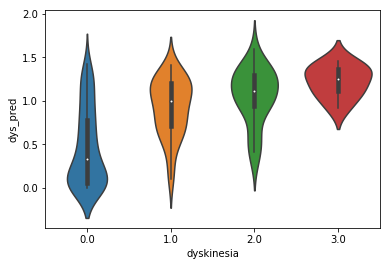

In [46]:
sns.violinplot(x="dyskinesia", y="dys_pred", data=y_valid[["measurement_id", "dyskinesia", "dys_pred"]].groupby("measurement_id").mean())

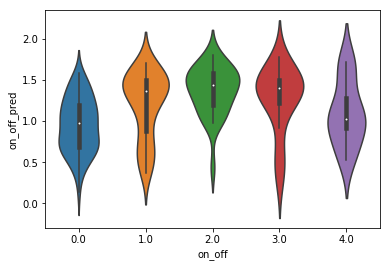

In [49]:
sns.violinplot(x="on_off", y="on_off_pred", data=y_valid[["measurement_id", "on_off", "on_off_pred"]].groupby("measurement_id").mean())

In [51]:
tmp = y_valid[["measurement_id", "dyskinesia", "dys_pred"]].groupby("measurement_id").mean()

In [53]:
((tmp.dyskinesia-tmp.dys_pred)**2).mean()

0.5668351230541496

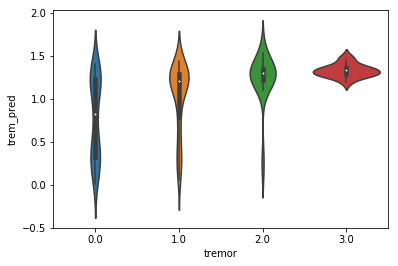

In [48]:
sns.violinplot(x="tremor", y="trem_pred", data=y_valid[["measurement_id", "tremor", "trem_pred"]].groupby("measurement_id").mean())

# dyskinesia only

In [75]:
import keras
num_cnn_layers = 5
num_lstm_layers = 1
num_lin_layers = 2
inputLayer = keras.layers.Input((1500, 3))
x = inputLayer


for i in range(num_cnn_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv1D(16, (3,), padding="same")(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.MaxPool1D((2,))(x)
for j in range(num_lstm_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.CuDNNLSTM(256, return_sequences=True)(x)
    x = keras.layers.LeakyReLU()(x)


x = keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x = keras.layers.Dense(200)(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dropout(0.5)(x)

x_shared_flattened = x

#tremor
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(100)(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1)(x)
x_dyskinesia = keras.layers.ReLU(name="dyskinesia", max_value=4)(x)



model = keras.Model(inputs=inputLayer, outputs=x_dyskinesia)
model.compile("adam", loss="mean_squared_error")

In [76]:
modelCheckpoint = keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/cnnlstm3_dysk_only.h5", save_best_only=True, verbose=True)
reduceLR = keras.callbacks.ReduceLROnPlateau(patience=5, verbose=True)
earlyStopping = keras.callbacks.EarlyStopping(patience=20, min_delta=0.01)
lr_schedule = keras.callbacks.LearningRateScheduler(lambda i, lr: lr*0.8)
history = model.fit(x=x_train, y=y_train.dyskinesia.values, validation_data=(x_valid,  y_valid.dyskinesia.values), callbacks=[earlyStopping, lr_schedule, modelCheckpoint], epochs=200, batch_size=128)

Train on 36987 samples, validate on 12434 samples
Epoch 1/200
36987/36987 [==============================] - 31s 842us/step - loss: 1.0463 - val_loss: 0.6559

Epoch 00001: val_loss improved from inf to 0.65589, saving model to /n/scratch2/ms994/cnnlstm3_dysk_only.h5
Epoch 2/200
36987/36987 [==============================] - 16s 421us/step - loss: 0.8198 - val_loss: 0.6373

Epoch 00002: val_loss improved from 0.65589 to 0.63734, saving model to /n/scratch2/ms994/cnnlstm3_dysk_only.h5
Epoch 3/200
36987/36987 [==============================] - 15s 419us/step - loss: 0.7844 - val_loss: 0.6280

Epoch 00003: val_loss improved from 0.63734 to 0.62795, saving model to /n/scratch2/ms994/cnnlstm3_dysk_only.h5
Epoch 4/200
36987/36987 [==============================] - 16s 421us/step - loss: 0.7515 - val_loss: 0.6190

Epoch 00004: val_loss improved from 0.62795 to 0.61899, saving model to /n/scratch2/ms994/cnnlstm3_dysk_only.h5
Epoch 5/200
36987/36987 [==============================] - 16s 420us/s

In [58]:
model = keras.models.load_model("/n/scratch2/ms994/cnnlstm3_dysk_only.h5")

In [59]:
y_pred_dysk_only = model.predict(x_valid)

In [60]:
y_pred_dysk_only = y_pred_dysk_only.reshape(-1)

In [62]:
y_valid.loc[:, "y_pred_dysk_only"] = y_pred_dysk_only

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [65]:
temp = y_valid[["measurement_id","dyskinesia", "y_pred_dysk_only"]].groupby("measurement_id").mean()

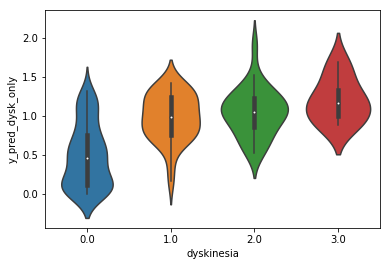

In [66]:
sns.violinplot("dyskinesia", "y_pred_dysk_only", data=temp)

# tremor only

In [77]:
import keras
num_cnn_layers = 5
num_lstm_layers = 1
num_lin_layers = 2
inputLayer = keras.layers.Input((1500, 3))
x = inputLayer


for i in range(num_cnn_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv1D(16, (3,), padding="same")(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.MaxPool1D((2,))(x)
for j in range(num_lstm_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.CuDNNLSTM(256, return_sequences=True)(x)
    x = keras.layers.LeakyReLU()(x)


x = keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x = keras.layers.Dense(200)(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dropout(0.5)(x)

x_shared_flattened = x

#tremor
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(100)(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1)(x)
x_dyskinesia = keras.layers.ReLU(name="tremor", max_value=4)(x)



model = keras.Model(inputs=inputLayer, outputs=x_dyskinesia)
model.compile("adam", loss="mean_squared_error")

In [78]:
modelCheckpoint = keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/cnnlstm3_tremor_only.h5", save_best_only=True, verbose=True)
reduceLR = keras.callbacks.ReduceLROnPlateau(patience=5, verbose=True)
earlyStopping = keras.callbacks.EarlyStopping(patience=20, min_delta=0.01)
lr_schedule = keras.callbacks.LearningRateScheduler(lambda i, lr: lr*0.8)
history = model.fit(x=x_train, y=y_train.tremor.values, validation_data=(x_valid,  y_valid.tremor.values), callbacks=[earlyStopping, lr_schedule, modelCheckpoint], epochs=200, batch_size=128)

Train on 36987 samples, validate on 12434 samples
Epoch 1/200
36987/36987 [==============================] - 32s 871us/step - loss: 1.0639 - val_loss: 0.7481

Epoch 00001: val_loss improved from inf to 0.74813, saving model to /n/scratch2/ms994/cnnlstm3_tremor_only.h5
Epoch 2/200
36987/36987 [==============================] - 16s 421us/step - loss: 0.8537 - val_loss: 0.7337

Epoch 00002: val_loss improved from 0.74813 to 0.73374, saving model to /n/scratch2/ms994/cnnlstm3_tremor_only.h5
Epoch 3/200
36987/36987 [==============================] - 16s 422us/step - loss: 0.8282 - val_loss: 0.7333

Epoch 00003: val_loss improved from 0.73374 to 0.73325, saving model to /n/scratch2/ms994/cnnlstm3_tremor_only.h5
Epoch 4/200
36987/36987 [==============================] - 16s 419us/step - loss: 0.7883 - val_loss: 0.7258

Epoch 00004: val_loss improved from 0.73325 to 0.72584, saving model to /n/scratch2/ms994/cnnlstm3_tremor_only.h5
Epoch 5/200
36987/36987 [==============================] - 16s

# on off only

In [79]:
import keras
num_cnn_layers = 5
num_lstm_layers = 1
num_lin_layers = 2
inputLayer = keras.layers.Input((1500, 3))
x = inputLayer


for i in range(num_cnn_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv1D(16, (3,), padding="same")(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.MaxPool1D((2,))(x)
for j in range(num_lstm_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.CuDNNLSTM(256, return_sequences=True)(x)
    x = keras.layers.LeakyReLU()(x)


x = keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x = keras.layers.Dense(200)(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dropout(0.5)(x)

x_shared_flattened = x

#tremor
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(100)(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1)(x)
x_dyskinesia = keras.layers.ReLU(name="on_off", max_value=4)(x)



model = keras.Model(inputs=inputLayer, outputs=x_dyskinesia)
model.compile("adam", loss="mean_squared_error")

In [80]:
modelCheckpoint = keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/cnnlstm3_on_off_only.h5", save_best_only=True, verbose=True)
reduceLR = keras.callbacks.ReduceLROnPlateau(patience=5, verbose=True)
earlyStopping = keras.callbacks.EarlyStopping(patience=20, min_delta=0.01)
lr_schedule = keras.callbacks.LearningRateScheduler(lambda i, lr: lr*0.8)
history = model.fit(x=x_train, y=y_train.on_off.values, validation_data=(x_valid,  y_valid.on_off.values), callbacks=[earlyStopping, lr_schedule, modelCheckpoint], epochs=200, batch_size=128)

Train on 36987 samples, validate on 12434 samples
Epoch 1/200
36987/36987 [==============================] - 33s 895us/step - loss: 2.0171 - val_loss: 1.7679

Epoch 00001: val_loss improved from inf to 1.76787, saving model to /n/scratch2/ms994/cnnlstm3_on_off_only.h5
Epoch 2/200
36987/36987 [==============================] - 16s 427us/step - loss: 1.7857 - val_loss: 1.8170

Epoch 00002: val_loss did not improve from 1.76787
Epoch 3/200
36987/36987 [==============================] - 15s 419us/step - loss: 1.8647 - val_loss: 1.8639

Epoch 00003: val_loss did not improve from 1.76787
Epoch 4/200
36987/36987 [==============================] - 16s 421us/step - loss: 1.7541 - val_loss: 1.7500

Epoch 00004: val_loss improved from 1.76787 to 1.74995, saving model to /n/scratch2/ms994/cnnlstm3_on_off_only.h5
Epoch 5/200
36987/36987 [==============================] - 16s 422us/step - loss: 1.8486 - val_loss: 1.7184

Epoch 00005: val_loss improved from 1.74995 to 1.71843, saving model to /n/scra